Following the basic attempt on using a PCA based model, combined with linear regression, we will use a neural netwrok.

Given the assignment one model must use deep learning. So i could switch to somekind of neural model for PCA, however, given the time related data a LSTM approach feels better. (for now) <br/>


In [1]:
# load prepared data set one (the whole set, including rul and averaged values)
from pandas import HDFStore

store = HDFStore('pd_train_enriched_rul_fd001.h5', mode='r')
pd_train_fd001 = store['pd']
store.close()

In [2]:
pd_train_fd001.sort_values(by=['unit', 'cycle'])
pd_train_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21,avgrul
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
pd_train_fd001['rul'].head()

0    191
1    190
2    189
3    188
4    187
Name: rul, dtype: int64

In [4]:
# also load test which is scaled
store = HDFStore('pd_test_fd001_scaled.h5', mode='r')
pd_test_fd001 = store['pd']
store.close()

In [5]:
pd_test_fd001.sort_values(by=['unit', 'cycle'])
pd_test_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,cycleoriginal
0,1,0.000000,0.65625,0.692308,0.0,0.0,0.596222,0.421968,0.282213,0.0,...,0.325766,0.152257,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620101,1
1,1,0.003311,0.34375,0.230769,0.0,0.0,0.182972,0.504023,0.225241,0.0,...,0.395573,0.277907,0.227707,0.0,0.500,0.0,0.0,0.645455,0.645719,2
2,1,0.006623,0.53125,0.538462,0.0,0.0,0.419566,0.464812,0.346129,0.0,...,0.325766,0.192892,0.533559,0.0,0.500,0.0,0.0,0.700001,0.681104,3
3,1,0.009934,0.77500,0.461538,0.0,0.0,0.413251,0.391585,0.449868,0.0,...,0.372304,0.217894,0.282358,0.0,0.250,0.0,0.0,0.627272,0.620382,4
4,1,0.013245,0.60000,0.461538,0.0,0.0,0.435335,0.471303,0.357975,0.0,...,0.325766,0.187890,0.337009,0.0,0.125,0.0,0.0,0.618183,0.676009,5


The test data has also the ground truth, i.e. when the test data was cut off it is known how many cycles the engine sill ran.

In [6]:
from pyspark.sql.types import StructType, StructField, IntegerType
import numpy as np

schema = StructType([
    StructField("max"    , IntegerType(), True)
])
 
# lets load the data, only one file
pd_rul_fd001 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/RUL_FD001.txt', schema=schema).toPandas()
pd_rul_fd001['unit'] = np.arange(1,len(pd_rul_fd001)+1)
pd_rul_fd001.head()

,max,unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [7]:
# find max wihtin test set
# cycle is normalised, so we need the 'original' value
pd_rul_test_fd001 = pd_test_fd001.groupby('unit')['cycleoriginal'].max().reset_index()
pd_rul_test_fd001.head()

,unit,cycleoriginal
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [8]:
# We need to combine the ground truth table with test so we can test against the remaining usefull lifetime (test set does not contain rul on loading)
pd_rul_fd001['max_rul'] = pd_rul_fd001['max'] + pd_rul_test_fd001['cycleoriginal']  # assume both same order
pd_rul_fd001.head()

,max,unit,max_rul
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [9]:
pd_rul_fd001.drop(columns=['max'], inplace=True) # to prevent duplicate max

In [10]:
# The test set stops at a point before the engine breaks down. So the maximum we find in test 
pd_test_fd001 = pd_test_fd001.merge(pd_rul_fd001, on=['unit'], how='left') # left join
pd_test_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,cycleoriginal,max_rul
0,1,0.000000,0.65625,0.692308,0.0,0.0,0.596222,0.421968,0.282213,0.0,...,0.152257,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620101,1,143
1,1,0.003311,0.34375,0.230769,0.0,0.0,0.182972,0.504023,0.225241,0.0,...,0.277907,0.227707,0.0,0.500,0.0,0.0,0.645455,0.645719,2,143
2,1,0.006623,0.53125,0.538462,0.0,0.0,0.419566,0.464812,0.346129,0.0,...,0.192892,0.533559,0.0,0.500,0.0,0.0,0.700001,0.681104,3,143
3,1,0.009934,0.77500,0.461538,0.0,0.0,0.413251,0.391585,0.449868,0.0,...,0.217894,0.282358,0.0,0.250,0.0,0.0,0.627272,0.620382,4,143
4,1,0.013245,0.60000,0.461538,0.0,0.0,0.435335,0.471303,0.357975,0.0,...,0.187890,0.337009,0.0,0.125,0.0,0.0,0.618183,0.676009,5,143


In [11]:
# same as earlier, now we calcualte the rul per cycle
pd_test_fd001['rul'] = pd_test_fd001['max_rul'] - pd_test_fd001['cycleoriginal']
pd_test_fd001.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,cycleoriginal,max_rul,rul
0,1,0.000000,0.65625,0.692308,0.0,0.0,0.596222,0.421968,0.282213,0.0,...,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620101,1,143,142
1,1,0.003311,0.34375,0.230769,0.0,0.0,0.182972,0.504023,0.225241,0.0,...,0.227707,0.0,0.500,0.0,0.0,0.645455,0.645719,2,143,141
2,1,0.006623,0.53125,0.538462,0.0,0.0,0.419566,0.464812,0.346129,0.0,...,0.533559,0.0,0.500,0.0,0.0,0.700001,0.681104,3,143,140
3,1,0.009934,0.77500,0.461538,0.0,0.0,0.413251,0.391585,0.449868,0.0,...,0.282358,0.0,0.250,0.0,0.0,0.627272,0.620382,4,143,139
4,1,0.013245,0.60000,0.461538,0.0,0.0,0.435335,0.471303,0.357975,0.0,...,0.337009,0.0,0.125,0.0,0.0,0.618183,0.676009,5,143,138


Now we have loaded the sets we need to figure out how we could determine the remaining cyles.<br/>
We already normalized all data but is that really a good thing for the number of (remaining) cycles? Nope. First run failed with normalised rul, we could try to denormalise. <br/>
Also the ground truth is not normalised (yet)<br/>
Se we do a second run with the rul unchanged, i.e. not normalised.

## LSTM

For a second model we use the long short the model (LSTM) since we have time related data (cycles)<br/>

First we use the training data to create a set of sequences / batches for training.

Note: partly base on Microsoft Azure example ()


So the data is scaled and we want to predict the rul (i.e. thats the target or dependent) <br/>
And our data is time related data, i.e its a time series with many variables.<br/>

We want to predict the rul within a resonable accuracy for a reasonable amount of remaingin cycles.<br/>
We may find that lstm is not the best model...<br/>

We may simplify by labeling the dataset (as suggested by the Micorosft Azure example)


In [12]:
# need to be sure the format fit the expectation of a LSTM (samples (total set of samples), time steps (or cycles) for each sequence, features for each timestep)

def generate_sequence(dataframe_subset_unit, sequence_length, sequence_columns):
    
    datamatrix_subset = dataframe_subset_unit[sequence_columns].values # for the given dataframe, which belongs to one engin (unit) we select the data for the given columns
    number_elements   = dataframe_subset_unit.shape[0] # number of rows, i.e. cycles for the one given engine
    
    # create sliding window over the rows in batches of a sequence_length
    # Note zip is not a compression thnigy, it generates iterators
    #                                   ensure the sliding window will end at last row
    for start_row, end_row in zip(range(0, number_elements - sequence_length), range(sequence_length, number_elements)):
        yield datamatrix_subset[start_row:end_row, :] # subset of row, all columns
    

In [13]:
# feature list 
features_columns = ['cycle','opset1', 'opset2', 'opset3',\
                    'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10', \
                    'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']

# Todo use averaged to see if it imporves the results

In [14]:
sequence_length = 42 # number of rows in one batch, for starters

In [15]:
val=list(generate_sequence(pd_train_fd001[pd_train_fd001['unit']==1], sequence_length, features_columns))
print(len(val))

150


In [16]:
#                                       subset for one unit, i.e. engine
sequences_generator = (list(generate_sequence(pd_train_fd001[ pd_train_fd001['unit']==unit ], sequence_length, features_columns))
                       for unit in pd_train_fd001['unit'].unique())

# use generator to create actual sequence/batches looping over all rows with sliding window and force datatype
all_sequences = np.concatenate(list(sequences_generator)).astype(np.float32)
print(all_sequences[:2])
print(pd_train_fd001[ pd_train_fd001['unit']==1 ].head(2))

[[[ 0.          0.45977011  0.16666669 ...,  0.          0.71317935
    0.72466224]
  [ 0.00277008  0.60919541  0.25       ...,  0.          0.66666669
    0.73101217]
  [ 0.00554017  0.25287357  0.75       ...,  0.          0.62790757
    0.62137532]
  ..., 
  [ 0.10803324  0.5         0.16666669 ...,  0.          0.54263586
    0.66652799]
  [ 0.11080332  0.68965518  0.83333331 ...,  0.          0.76744264
    0.75973558]
  [ 0.11357341  0.52873564  0.16666669 ...,  0.          0.66666669
    0.66390479]]

 [[ 0.00277008  0.60919541  0.25       ...,  0.          0.66666669
    0.73101217]
  [ 0.00554017  0.25287357  0.75       ...,  0.          0.62790757
    0.62137532]
  [ 0.00831025  0.54022986  0.5        ...,  0.          0.57364428
    0.66238511]
  ..., 
  [ 0.11080332  0.68965518  0.83333331 ...,  0.          0.76744264
    0.75973558]
  [ 0.11357341  0.52873564  0.16666669 ...,  0.          0.66666669
    0.66390479]
  [ 0.11634349  0.34482759  0.91666669 ...,  0.          0

In [17]:
# quick check
print("lenght of all sequences ", len(all_sequences), " shape ", all_sequences.shape)

lenght of all sequences  16431  shape  (16431, 42, 25)


For our first attempt we will use the calculated rul. Later we may try to use label(s), then the problem changes into a classification problem. Might be easier / better to predict properly instead of trying to predict a more 'exact' number of remaining cycles.

In [18]:
# use sliding window (same as sequence generator) to move over target/outcome, i.e. the rul
# Need to rethink dimension. Intensions was to pass 3d to Dense Layer but that isnt accpeted, even if you pass input shape.
def generate_outcome(dataframe_subset_unit, sequence_length, sequence_columns):
    datamatrix_subset = dataframe_subset_unit[sequence_columns].values # for the given dataframe, which belongs to one engin (unit) we select the data for the given columns
    
    number_elements   = dataframe_subset_unit.shape[0] # number of rows, i.e. cycles for the one given engine
    #print("ne ", number_elements)
    # create sliding window over the rows in batches of a sequence_length
    # Note zip is not a compression thnigy, it generates iterators
    #                                   ensure the sliding window will end at last row
    for start_row, end_row in zip(range(0, number_elements - sequence_length), range(sequence_length, number_elements)):
        #print(start_row, end_row)
        yield datamatrix_subset[start_row:end_row, :].max() # subset of row, all columns
    #return datamatrix_subset[sequence_length:number_elements, :]
      

In [19]:
outcome_column = ['rul']

outcome_generator = (list(generate_outcome(pd_train_fd001[ pd_train_fd001['unit']==unit ], sequence_length, outcome_column))
                       for unit in np.array( pd_train_fd001['unit'].unique() )
                    )


In [20]:
pd_train_fd001['rul'].head(10)

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: rul, dtype: int64

In [21]:
all_outcome = np.concatenate(list(outcome_generator)).astype(np.float32)
print(all_outcome[:10])
print(all_outcome.shape)
#print(pd_train_fd001[ pd_train_fd001['unit']==1 ]['rul'].head(7))


[ 191.  190.  189.  188.  187.  186.  185.  184.  183.  182.]
(16431,)


In [22]:
# quick check
print("lenght of all outcome ", len(all_outcome), " shape ", all_outcome.shape)

lenght of all outcome  16431  shape  (16431,)


In [23]:
number_of_output_features = 1 # or the rul
number_of_input_features = all_sequences.shape[2] # could use lenght of features_columns

print(sequence_length, number_of_input_features, all_sequences.shape,  all_outcome.shape)



42 25 (16431, 42, 25) (16431,)


In [24]:
from keras.optimizers import Adadelta
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras import losses
from keras import metrics

Using TensorFlow backend.


In [25]:
# https://keras.io/metrics/
# https://keras.io/layers/core/#dense
# https://keras.io/layers/core/#dropout
# https://keras.io/layers/recurrent/#lstm
# https://keras.io/losses/
# https://keras.io/optimizers/#usage-of-optimizers

model = Sequential()

model.add(LSTM(input_shape=(sequence_length, number_of_input_features), units = 2 * number_of_input_features, return_sequences=True))
model.add(Dropout(0.15)) # how much should we really drop to prevent overfitting?
model.add(LSTM(units = number_of_input_features, return_sequences=False))
model.add(Dropout(0.25)) # how much should we really drop to prevent overfitting?

#dense_input_shape = all_outcome.shape
#print(dense_input_shape)

#model.add(Flatten())
#model.add(Dense(units=number_of_output_features, activation='relu'))    # doesnt work?: input_shape=(all_outcome.shape[0], all_outcome.shape[1], all_outcome.shape[2]) ))

model.add(Dense(units=1, activation='linear'))
#model.add(Dense(units=number_of_output_features, activation='relu', input_shape=(16432,42,1)))    # doesnt work?: input_shape=(all_outcome.shape[0], all_outcome.shape[1], all_outcome.shape[2]) ))

# epsilon cannot be None, but Keras error isnt very clear on this. sigh.
model.compile(loss=losses.mean_squared_error, optimizer=Adadelta(lr=1.0, rho=0.95, decay=0.0), metrics=['mae','mse','msle']) # try to use same metrics as for the PCA attempt

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 42, 50)            15200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
# https://keras.io/callbacks/#callback

from keras.callbacks import EarlyStopping, ModelCheckpoint

# use the model, 
#history = model.fit(all_sequences, all_outcome, epochs=100, batch_size=200)

history = model.fit(all_sequences, all_outcome, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       #ModelCheckpoint('',monitor='val_loss', save_best_only=True, mode='min', verbose=1)
                      ]
          )


Train on 15609 samples, validate on 822 samples
Epoch 1/100
6s - loss: 18773.0391 - mean_absolute_error: 123.6198 - mean_squared_error: 18773.0391 - mean_squared_logarithmic_error: 9.6994 - val_loss: 17493.3618 - val_mean_absolute_error: 118.8135 - val_mean_squared_error: 17493.3618 - val_mean_squared_logarithmic_error: 5.4757
Epoch 2/100
6s - loss: 17051.1873 - mean_absolute_error: 116.4750 - mean_squared_error: 17051.1873 - mean_squared_logarithmic_error: 4.6524 - val_loss: 16182.7722 - val_mean_absolute_error: 113.1640 - val_mean_squared_error: 16182.7722 - val_mean_squared_logarithmic_error: 3.8449
Epoch 3/100
5s - loss: 15794.0131 - mean_absolute_error: 110.9545 - mean_squared_error: 15794.0131 - mean_squared_logarithmic_error: 3.3971 - val_loss: 14985.7191 - val_mean_absolute_error: 107.7452 - val_mean_squared_error: 14985.7191 - val_mean_squared_logarithmic_error: 2.8924
Epoch 4/100
5s - loss: 14627.4595 - mean_absolute_error: 105.5424 - mean_squared_error: 14627.4595 - mean_squ

In [27]:
# erm, hwihc keyse are there (same as in logging when verbose...
print(history.history.keys())

dict_keys(['val_mean_squared_logarithmic_error', 'val_loss', 'mean_absolute_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_squared_logarithmic_error', 'val_mean_squared_error'])


In [28]:
# quick check
print(history.history['mean_squared_logarithmic_error'])

[9.6994079767882511, 4.6523573389883666, 3.3971240900657858, 2.604717560860446, 2.0901466581088117, 1.7078879798991438, 1.4236115786486871, 1.2152729930269153, 1.0404433199502297, 0.90403083170527221, 0.79139813288375171, 0.70155627250258978, 0.62878873119654233, 0.56544502683113229, 0.51695473293673411, 0.47229444585681857, 0.4374153874893269, 0.40605173976869358, 0.37945241947842789, 0.35628000809263621, 0.33743236085378625, 0.32072132531818659, 0.30855852312224197, 0.29615954527505745, 0.28657712736077218, 0.27808974286435972, 0.27033191820233915, 0.26536586666269085, 0.26066536123411671, 0.2550079525891758, 0.24977673689848914, 0.24942904469815519, 0.24823144901737412, 0.24467193407418672, 0.24308874732680183, 0.24187906763770364, 0.24069568854107193, 0.23939987944433205, 0.23779743212558083, 0.23838770788792302, 0.23793277444097294, 0.23829034374650571, 0.23791766849835896, 0.23746661344018399, 0.23762414421752792, 0.23951257677560614, 0.23755996430528883, 0.23719645266316305, 0.2

In [29]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


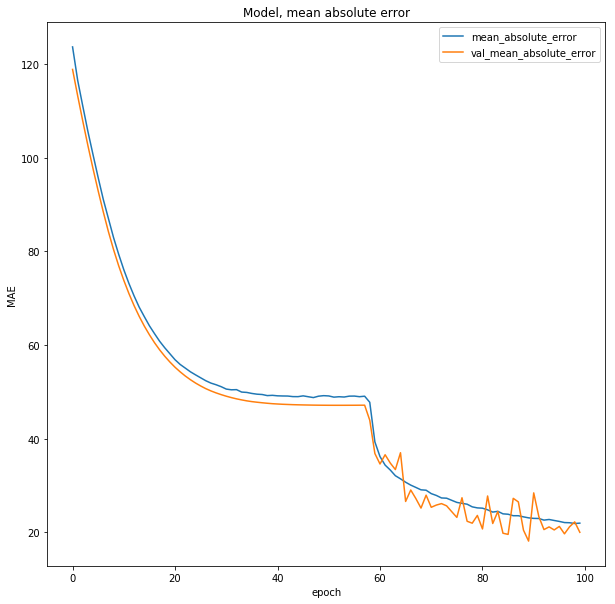

In [30]:
plt.figure(figsize=(10,10))
#plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])


plt.legend(['mean_absolute_error', 'val_mean_absolute_error'], loc='upper right')
plt.title('Model, mean absolute error')
plt.ylabel('MAE')
plt.xlabel('epoch')

plt.show()

   Mean absolute error is low, so its looking good. Though we should be carefull with interpreting this on its own.

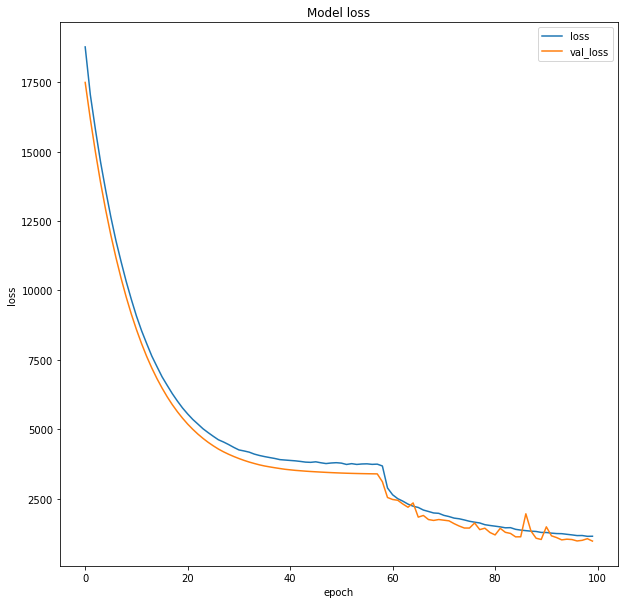

In [31]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Loss is low, so its looking good. Again, we should be carefull with interpretation.

In [32]:
# more checks on the model quality
# https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# https://keras.io/models/model/#evaluate
scores = model.evaluate(all_sequences, all_outcome, verbose=1, batch_size=200)
print()
print(model.metrics_names)
print(scores)

16400/16431 [============================>.] - ETA: 0s
['loss', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']
[969.8901470122338, 19.458367484288136, 969.8901470122338, 0.030754034175328883]


Lets use the test set to test the model.

Firts, generate sequence for testing, actually a subset


In [33]:
# laste sequence of test per engine
sequences_test_last = [ pd_test_fd001[pd_test_fd001['unit'] == unit][features_columns].values[-sequence_length:]
                       for unit in pd_test_fd001['unit'].unique() if len(pd_test_fd001[pd_test_fd001['unit'] == unit]) >= sequence_length]
#print(sequences_test_last[:2])
sequences_test_last = np.asarray(sequences_test_last).astype(np.float32)
#print(sequences_test_last[:2])
print(sequences_test_last.shape)

(96, 42, 25)


In [34]:
# Now for the y values / targets same subset 
y_mask = [len(pd_test_fd001[pd_test_fd001['unit'] == unit]) >= sequence_length for unit in pd_test_fd001['unit'].unique()]
#print(y_mask) # mask cto filter

outcome_array_test_last = pd_test_fd001.groupby('unit')['rul'].nth(-1)[y_mask].values
outcome_array_test_last = outcome_array_test_last.reshape(outcome_array_test_last.shape[0],1).astype(np.float32)
print(outcome_array_test_last.shape)
#print(outcome_array_test_last)

(96, 1)


In [35]:
# generate testscocre, to be compared with the training scores
scores_test = model.evaluate(sequences_test_last, outcome_array_test_last, verbose=1)

print()
print(model.metrics_names)
print(scores_test)

32/96 [=========>....................] - ETA: 0s
['loss', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']
[763.4459228515625, 22.011716206868488, 763.4459228515625, 0.27323446174462634]


In [36]:
test_y_predicted = model.predict(sequences_test_last)


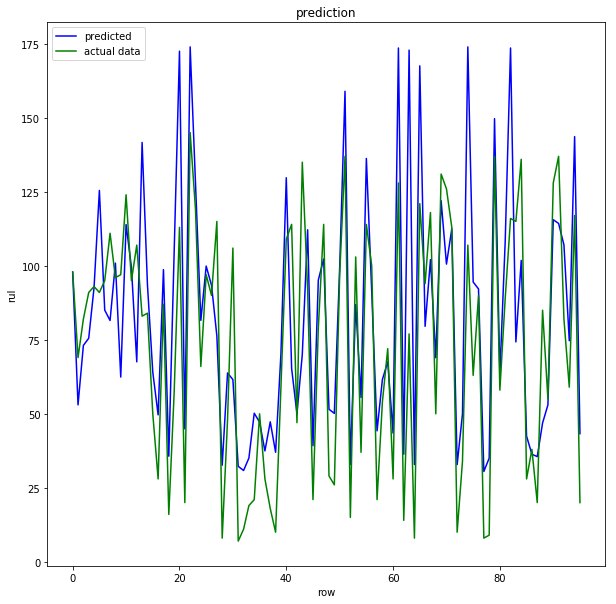

In [37]:
plt.figure(figsize=(10, 10))

plt.plot(test_y_predicted, color="blue")
plt.plot(outcome_array_test_last, color="green")

plt.title('prediction')
plt.ylabel('rul')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

The predictions are close, though sometimes there's a difference of a cycle of 20. <br/>

So lets try with different settings.

https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/ <br/>
https://www.analyticsvidhya.com/blog/2016/10/tutorial-optimizing-neural-networks-using-keras-with-image-recognition-case-study/#seven


In [38]:
sequence_length = 50 # from 42 to 50.

In [39]:
# regenerate sets so it will al fit

sequences_generator = (list(generate_sequence(pd_train_fd001[ pd_train_fd001['unit']==unit ], sequence_length, features_columns))
                       for unit in pd_train_fd001['unit'].unique())

# use generator to create actual sequence/batches looping over all rows with sliding window and force datatype
all_sequences = np.concatenate(list(sequences_generator)).astype(np.float32)
#print(all_sequences[:2])
#print(pd_train_fd001[ pd_train_fd001['unit']==1 ].head(2))

In [40]:
outcome_generator = (list(generate_outcome(pd_train_fd001[ pd_train_fd001['unit']==unit ], sequence_length, outcome_column))
                       for unit in np.array( pd_train_fd001['unit'].unique() )
                    )

all_outcome = np.concatenate(list(outcome_generator)).astype(np.float32)

In [41]:

model = Sequential()

model.add(LSTM(input_shape=(sequence_length, number_of_input_features), units = 2 * number_of_input_features, return_sequences=True))
model.add(Dropout(0.2)) # increased from .15 how much should we really drop to prevent overfitting?
model.add(LSTM(units = number_of_input_features, return_sequences=False))
model.add(Dropout(0.2)) # increased from .15 how much should we really drop to prevent overfitting?

model.add(Dense(units=1, activation='linear'))
# epsilon cannot be None, but Keras error isnt very clear on this. sigh.
model.compile(loss=losses.mean_squared_error, optimizer=Adadelta(rho=0.95, decay=0.1), metrics=['mae','mse','msle']) # try to use same metrics as for the PCA attempt. dropped lr, incresed deacy from 0.0 to 0.1

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            15200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
# inclease epochs from 100 to 1000.

batch_size = int(len(all_sequences) / 32)
print("batch_size ", batch_size)

history_2 = model.fit(all_sequences, all_outcome, epochs=1000, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       #ModelCheckpoint('',monitor='val_loss', save_best_only=True, mode='min', verbose=1)
                      ]
          )

batch_size  488
Train on 14849 samples, validate on 782 samples
Epoch 1/1000
4s - loss: 21046.0535 - mean_absolute_error: 133.3133 - mean_squared_error: 21046.0535 - mean_squared_logarithmic_error: 17.8652 - val_loss: 20182.1216 - val_mean_absolute_error: 130.4367 - val_mean_squared_error: 20182.1216 - val_mean_squared_logarithmic_error: 11.0392
Epoch 2/1000
4s - loss: 20162.9383 - mean_absolute_error: 129.9705 - mean_squared_error: 20162.9383 - mean_squared_logarithmic_error: 9.9490 - val_loss: 19740.5089 - val_mean_absolute_error: 128.7346 - val_mean_squared_error: 19740.5089 - val_mean_squared_logarithmic_error: 9.0563
Epoch 3/1000
4s - loss: 19855.8867 - mean_absolute_error: 128.7805 - mean_squared_error: 19855.8867 - mean_squared_logarithmic_error: 8.7399 - val_loss: 19531.7030 - val_mean_absolute_error: 127.9208 - val_mean_squared_error: 19531.7030 - val_mean_squared_logarithmic_error: 8.3457
Epoch 4/1000
4s - loss: 19708.0023 - mean_absolute_error: 128.2107 - mean_squared_error:

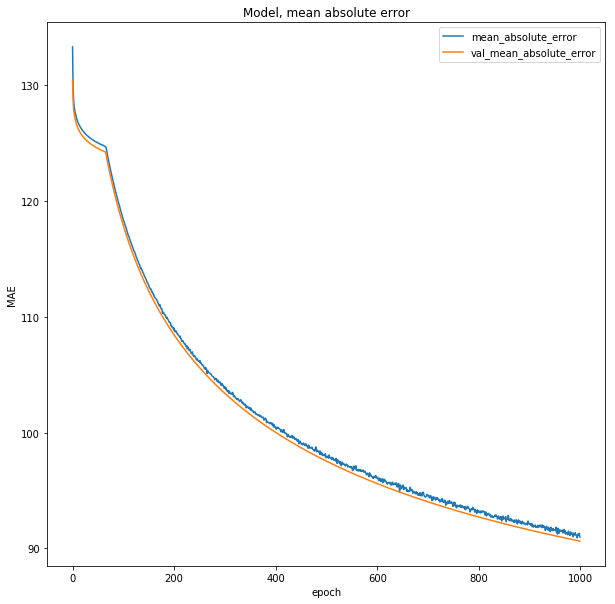

In [44]:
plt.figure(figsize=(10,10))

plt.plot(history_2.history['mean_absolute_error']    )
plt.plot(history_2.history['val_mean_absolute_error'])


plt.legend(['mean_absolute_error', 'val_mean_absolute_error','mean_absolute_error', 'val_mean_absolute_error'], loc='upper right')
plt.title('Model, mean absolute error')
plt.ylabel('MAE')
plt.xlabel('epoch')

plt.show()

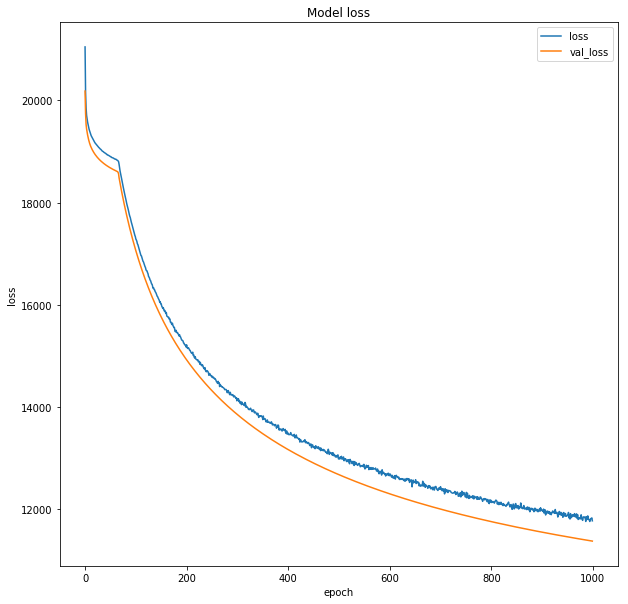

In [45]:
plt.figure(figsize=(10,10))

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])


plt.legend(['loss', 'val_loss','loss', 'val_loss'], loc='upper right')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Doesnt seem to have improved much , lets check the numbers

In [46]:
# more checks on the model quality
# https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# https://keras.io/models/model/#evaluate
scores = model.evaluate(all_sequences, all_outcome, verbose=1, batch_size=batch_size)
print()
print(model.metrics_names)
print(scores)

15616/15631 [============================>.] - ETA: 0s
['loss', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']
[11557.442542036515, 91.061623044514576, 11557.442542036515, 1.2374548589677623]


Yep, all parameters got worse...

In [50]:
from keras.optimizers import Adamax 

model = Sequential()

model.add(LSTM(input_shape=(sequence_length, number_of_input_features), units = 2 * number_of_input_features, return_sequences=True))
model.add(Dropout(0.2)) # increased from .15 how much should we really drop to prevent overfitting?
model.add(LSTM(units = number_of_input_features, return_sequences=False))
model.add(Dropout(0.2)) # increased from .15 how much should we really drop to prevent overfitting?

model.add(Dense(units=1, activation='linear'))
# epsilon cannot be None, but Keras error isnt very clear on this. sigh.
model.compile(loss=losses.mean_squared_error, optimizer=Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, decay=0.0), metrics=['mae','mse','msle']) # try to use same metrics as for the PCA attempt. dropped lr, incresed deacy from 0.0 to 0.1

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 50)            15200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________
None


In [51]:

history_2 = model.fit(all_sequences, all_outcome, epochs=1000, batch_size=100, validation_split=0.05, verbose=2,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       #ModelCheckpoint('',monitor='val_loss', save_best_only=True, mode='min', verbose=1)
                      ]
          )

Train on 14849 samples, validate on 782 samples
Epoch 1/1000
10s - loss: 19531.7478 - mean_absolute_error: 127.4871 - mean_squared_error: 19531.7478 - mean_squared_logarithmic_error: 8.4916 - val_loss: 18317.8389 - val_mean_absolute_error: 123.0853 - val_mean_squared_error: 18317.8389 - val_mean_squared_logarithmic_error: 5.6467
Epoch 2/1000
10s - loss: 17718.8264 - mean_absolute_error: 120.1817 - mean_squared_error: 17718.8264 - mean_squared_logarithmic_error: 4.6376 - val_loss: 16694.6948 - val_mean_absolute_error: 116.3049 - val_mean_squared_error: 16694.6948 - val_mean_squared_logarithmic_error: 3.7459
Epoch 3/1000
10s - loss: 16146.5802 - mean_absolute_error: 113.4366 - mean_squared_error: 16146.5802 - mean_squared_logarithmic_error: 3.2105 - val_loss: 15178.5499 - val_mean_absolute_error: 109.5933 - val_mean_squared_error: 15178.5499 - val_mean_squared_logarithmic_error: 2.6829
Epoch 4/1000
10s - loss: 14694.2896 - mean_absolute_error: 106.8078 - mean_squared_error: 14694.2896 - 

In [54]:
# regenrate test sequence
# regenerate sets so it will al fit




sequences_generator = (list(generate_sequence(pd_train_fd001[ pd_train_fd001['unit']==unit ], sequence_length, features_columns))
                       for unit in pd_train_fd001['unit'].unique())

# use generator to create actual sequence/batches looping over all rows with sliding window and force datatype
all_sequences = np.concatenate(list(sequences_generator)).astype(np.float32)

outcome_generator = (list(generate_outcome(pd_train_fd001[ pd_train_fd001['unit']==unit ], sequence_length, outcome_column))
                       for unit in np.array( pd_train_fd001['unit'].unique() )
                    )

all_outcome = np.concatenate(list(outcome_generator)).astype(np.float32)

In [56]:
# laste sequence of test per engine
sequences_test_last = [ pd_test_fd001[pd_test_fd001['unit'] == unit][features_columns].values[-sequence_length:]
                       for unit in pd_test_fd001['unit'].unique() if len(pd_test_fd001[pd_test_fd001['unit'] == unit]) >= sequence_length]
sequences_test_last = np.asarray(sequences_test_last).astype(np.float32)
print(sequences_test_last.shape)

(93, 50, 25)


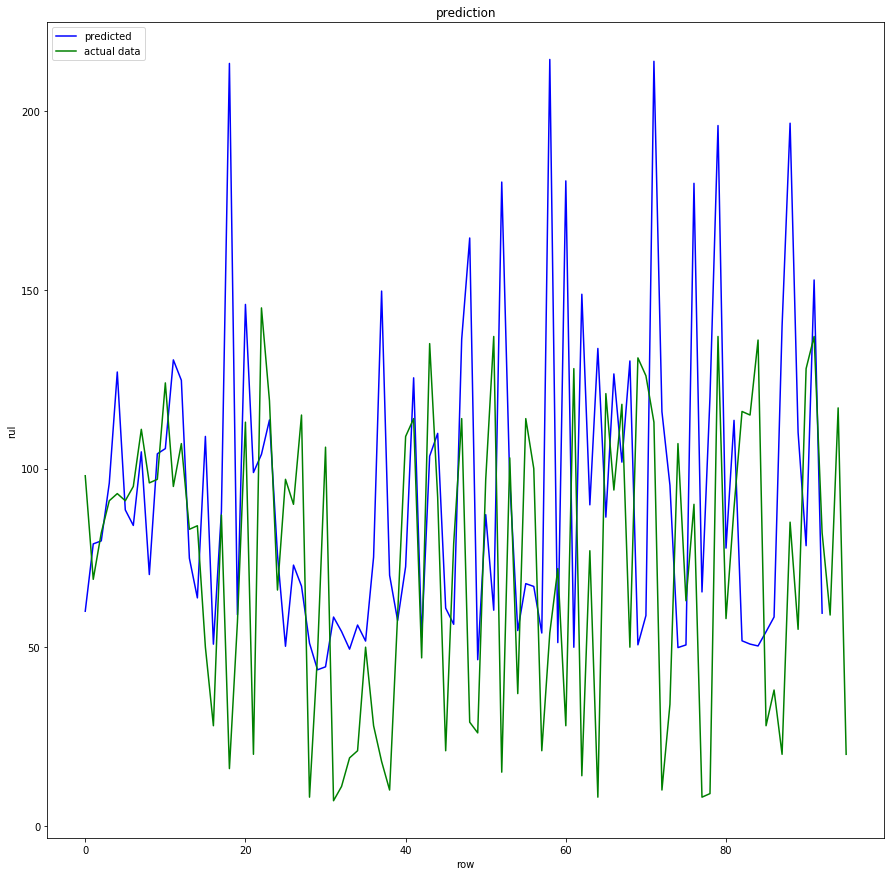

In [57]:
# test this model
test_y_predicted = model.predict(sequences_test_last)

plt.figure(figsize=(15, 15))

plt.plot(test_y_predicted, color="blue")
plt.plot(outcome_array_test_last, color="green")

plt.title('prediction')
plt.ylabel('rul')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

In [53]:
# more checks on the model quality
# https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# https://keras.io/models/model/#evaluate
scores = model.evaluate(all_sequences, all_outcome, verbose=1, batch_size=batch_size)
print()
print(model.metrics_names)
print(scores)

15600/15631 [============================>.] - ETA: 0s
['loss', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']
[566.53255567318206, 15.136565394627599, 566.53255567318206, 0.016781898223992869]


## Conclusion LSTM models

Overview of score LSTM models 1,2 and 3.<br/>


| model  | loss function     | batch size |                loss |  mean absolute error | mean squared error | mean squared logarithmic error |
|--------|-----------|--------|---------------------|----------------------|--------------------|--------------------------------|
|     1  |  Adadelta | 200    | 763.4459228515625   |  22.011716206868488  | 763.4459228515625  |            0.27323446174462634 |
|     2  |  Adadelta | 488    | 11557.442542036515  |  91.061623044514576  | 11557.442542036515 |             1.2374548589677623 |
|     3  |  Adamax   | 100    | 566.53255567318206  |  15.136565394627599  | 566.53255567318206 |         0.016781898223992869   |

The smaller batch helps a lot; it even finishes early.<br/>
Though the figure doesn't really convince.